In [1]:
using Pkg
Pkg.activate(".")
using Revise

using WAV, Audio911
using PyCall
librosa = pyimport("librosa");

  Activating project at `~/Documents/Aclai/audio-rules2024`


## Audio features extraction function

In [3]:
nan_replacer!(x::AbstractArray{Float64}) = replace!(x, NaN => 0.0)

function afe_mel(audio::Audio;
    # -------------------------------- parameters -------------------------------- #
    # audio module
    sr = audio.sr,
    norm = true,
    speech_detection = false,
    # stft module
    stft_length = 512,
    win_type = (:hann, :periodic),
    win_length = 512,
    overlap_length = 256,
    stft_norm = :power,                      # :power, :magnitude, :pow2mag
    # mel filterbank module
    nbands = 26,
    scale = :mel_htk  ,                      # :mel_htk, :mel_slaney, :erb, :bark
    melfb_norm = :bandwidth,                 # :bandwidth, :area, :none
    freq_range = (0, round(Int, audio.sr / 2)),
    # mel spectrogram module
    db_scale = false,
)
    # --------------------------------- functions -------------------------------- #
    stftspec = get_stft(
        audio=audio,
        stft_length=stft_length,
        win_type=win_type,
        win_length=win_length,
        overlap_length=overlap_length,
        norm=stft_norm
    );

    # mel filterbank module
    melfb = get_melfb(
        stft=stftspec,
        nbands=nbands,
        scale=scale,
        norm=melfb_norm,
        freq_range=freq_range
    );

    # mel spectrogram module
    get_melspec(
        stft=stftspec,
        fbank=melfb,
        db_scale=db_scale
    )
end

function afe_mfcc(melspec::MelSpec;
    # -------------------------------- parameters -------------------------------- #
    # mfcc module
    ncoeffs = 13,
    rectification = :log,                    # :log, :cubic_root
    dither = false,
)

    # --------------------------------- functions -------------------------------- #
    # mfcc module
    get_mfcc(
        source=melspec,
        ncoeffs=ncoeffs,
        rectification=rectification,
        dither=dither,
    )
end
;

## Load audiofile

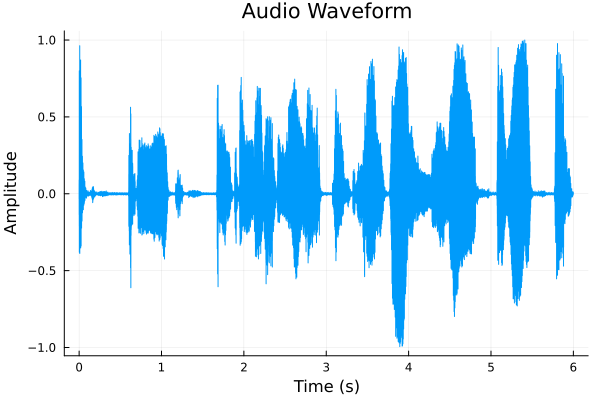

In [4]:
TESTPATH = joinpath(dirname(pathof(Audio911)), "..", "test")
TESTFILE = "common_voice_en_23616312.wav"
# TESTFILE = "104_1b1_Al_sc_Litt3200_4.wav"
wavfile = joinpath(TESTPATH, TESTFILE)

sr = 8000
audio = load_audio(file=wavfile, sr=sr, norm=true);
plot(audio)

## Mel spectrogram & Mfcc features extraction

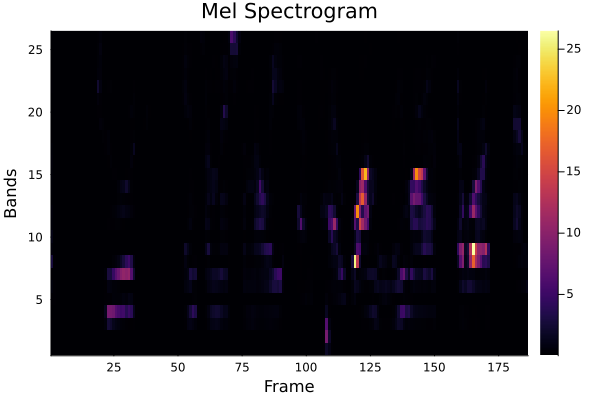

In [5]:
n_mel_bands = 26
melspec = afe_mel(audio; nbands=n_mel_bands, db_scale=false)
display(melspec)

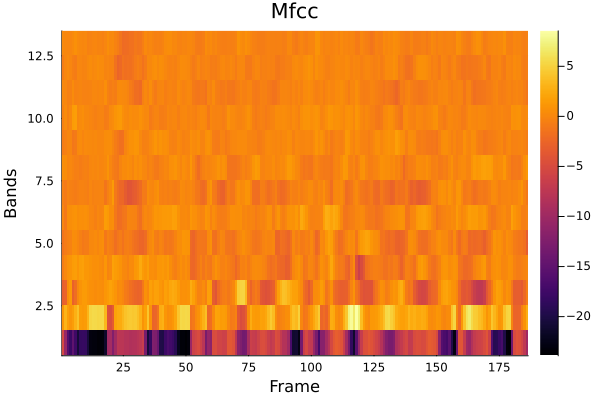

In [6]:
mfccspec = afe_mfcc(melspec)
display(mfccspec)

## Perform librosa inverse mfcc > mel spectrogram

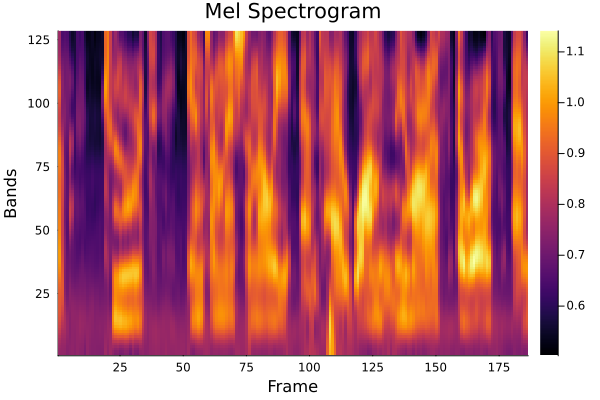

In [7]:
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfccspec.mfcc, n_mels=128)
reconstructed_spec = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(reconstructed_spec)

## Perform librosa inverse mel > audio

In [15]:
inv_audio = librosa.feature.inverse.mfcc_to_audio(mfccspec.mfcc, sr=audio.sr, n_fft=512, hop_length=256, win_length=512, n_iter=32)
wavplay(inv_audio, audio.sr)

librosa mfcc comes from a lightly different mel specttrogram algo:

In [16]:
n_mel_bands = 26
melspec = afe_mel(audio; nbands=n_mel_bands, db_scale=false)
melspec.spec

26×186 Matrix{Float64}:
 0.00209961  0.00227671   0.00192725   …  0.00106025  0.00145719   0.00184164
 0.00849213  0.00243335   0.00300688      0.00297311  0.00378906   0.00453087
 0.105323    0.0273716    0.0120206       0.0150713   0.0561911    0.13705
 0.029294    0.0128355    0.00303172      0.00895816  0.05181      0.0827324
 0.112277    0.0907353    0.00185529      0.00463772  0.0068507    0.0311031
 0.508389    0.154963     0.00116053   …  0.392348    0.443058     0.86262
 0.102685    0.0394131    0.00096481      0.116269    0.175345     0.172337
 2.74642     0.112813     0.00118495      0.511515    0.42121      0.522027
 0.454307    0.0173191    0.000696683     0.419474    0.582821     0.391644
 0.98091     0.0312834    0.00115635      0.468906    0.0225954    0.00419328
 ⋮                                     ⋱                           ⋮
 0.114866    0.00757833   0.000657327     1.16862     0.0429596    0.00610678
 0.0457842   0.00323509   0.000889677     0.208322    0.0633317

In [17]:
lmel = librosa.feature.melspectrogram(y=audio.data, sr=audio.sr, n_fft=512, hop_length=256, win_length=512, n_mels=n_mel_bands, window="hann", center=true, power=2, htk=true)

26×188 Matrix{Float64}:
 0.000943156  0.00209961  0.00227671   …  0.00184164  0.00175949
 0.00406913   0.00849213  0.00243335      0.00453087  0.00604816
 0.0546634    0.105323    0.0273716       0.13705     0.0279048
 0.02958      0.029294    0.0128355       0.0827324   0.00584782
 0.012946     0.112277    0.0907353       0.0311031   0.0144172
 0.197303     0.508389    0.154963     …  0.86262     0.0387249
 0.0799538    0.102685    0.0394131       0.172337    0.0134189
 0.933317     2.74642     0.112813        0.522027    0.035424
 0.634834     0.454307    0.0173191       0.391644    0.00730987
 1.78734      0.98091     0.0312834       0.00419328  0.000585347
 ⋮                                     ⋱              
 0.323182     0.114866    0.00757833      0.00610678  0.000968105
 0.240888     0.0457842   0.00323509      0.00805885  0.000290052
 0.246942     0.045981    0.00141283      0.0103153   8.43233e-5
 0.147511     0.045318    0.000550067  …  0.0133198   5.34688e-5
 0.394456     

The librosa mel spectrogram differs from Audio911, audioflux and matlab in size: it adds two more windows in calculation.
This could be why coming back to the original audio is not working, with different mel spectrograms algos.

In [18]:
lmfcc = librosa.feature.mfcc(y=audio.data, sr=audio.sr, n_mfcc=26, n_fft=512, hop_length=256, win_length=512)
inv_audio = librosa.feature.inverse.mfcc_to_audio(lmfcc, sr=audio.sr, n_fft=512, hop_length=256, win_length=512, n_iter=32)
wavplay(inv_audio, audio.sr)

## Original mel spectrogram comparision

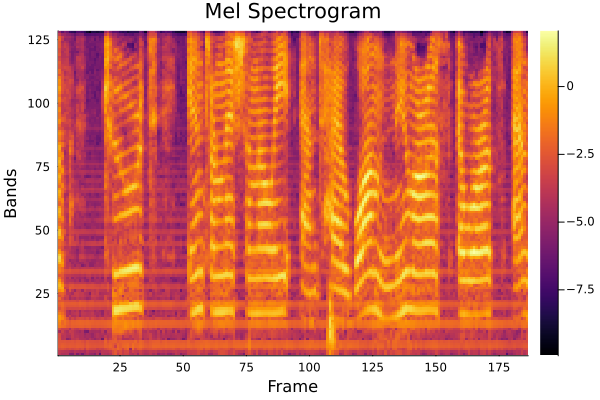

In [48]:
melspec = afe_mel(audio; nbands=n_mel_bands, db_scale=true)
display(melspec)

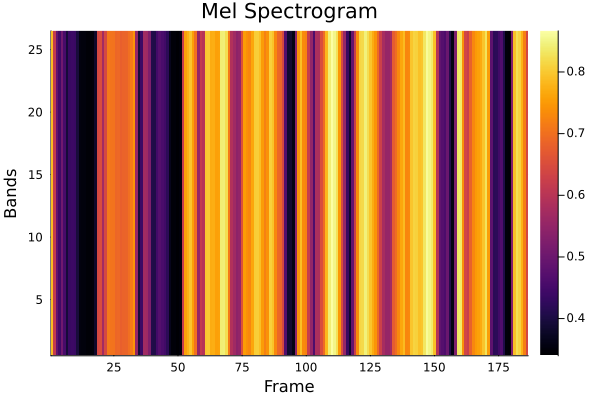

In [33]:
mfcc_s1 = zeros(size(mfccspec.mfcc))
mfcc_s1[1, :] = mfccspec.mfcc[1, :]
mfcc1 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s1,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc1.mfcc, n_mels=melspec.nbands)
rec_spc1 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc1)

In [36]:
inv_audio = librosa.feature.inverse.mfcc_to_audio(mfcc1.mfcc, sr=audio.sr, n_mels=26, n_fft=512, hop_length=256, win_length=512, window="hann", n_iter=32)
wavplay(inv_audio, audio.sr)

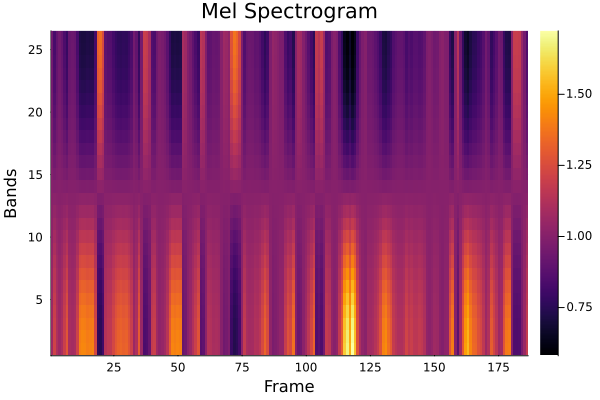

In [37]:
mfcc_s2 = zeros(size(mfccspec.mfcc))
mfcc_s2[2, :] = mfccspec.mfcc[2, :]
mfcc2 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s2,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc2.mfcc, n_mels=melspec.nbands)
rec_spc2 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc2)

In [38]:
inv_audio = librosa.feature.inverse.mfcc_to_audio(mfcc2.mfcc, sr=audio.sr, n_mels=26, n_fft=512, hop_length=256, win_length=512, window="hann", n_iter=32)
wavplay(inv_audio, audio.sr)

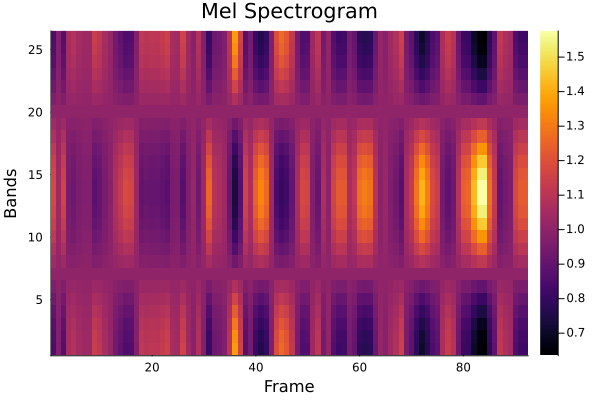

In [72]:
mfcc_s3 = zeros(size(mfccspec.mfcc))
mfcc_s3[3, :] = mfccspec.mfcc[3, :]
mfcc3 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s3,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc3.mfcc, n_mels=melspec.nbands)
rec_spc3 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc3)

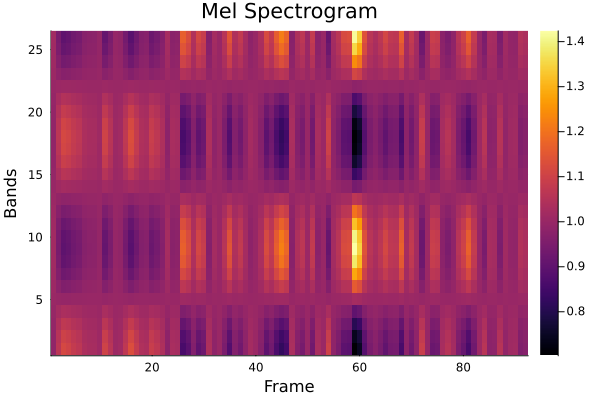

In [83]:
mfcc_s4 = zeros(size(mfccspec.mfcc))
mfcc_s4[4, :] = mfccspec.mfcc[4, :]
mfcc4 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s4,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc4.mfcc, n_mels=melspec.nbands)
rec_spc4 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc4)

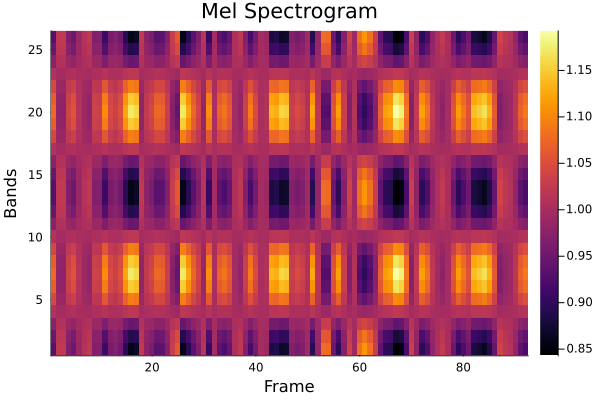

In [84]:
mfcc_s5 = zeros(size(mfccspec.mfcc))
mfcc_s5[5, :] = mfccspec.mfcc[5, :]
mfcc5 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s5,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc5.mfcc, n_mels=melspec.nbands)
rec_spc5 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc5)

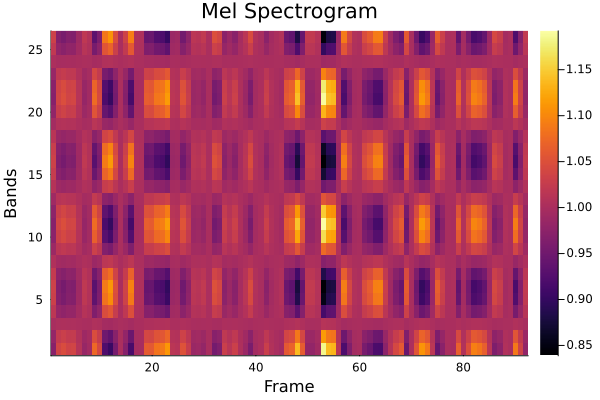

In [75]:
mfcc_s6 = zeros(size(mfccspec.mfcc))
mfcc_s6[6, :] = mfccspec.mfcc[6, :]
mfcc6 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s6,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc6.mfcc, n_mels=melspec.nbands)
rec_spc6 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc6)

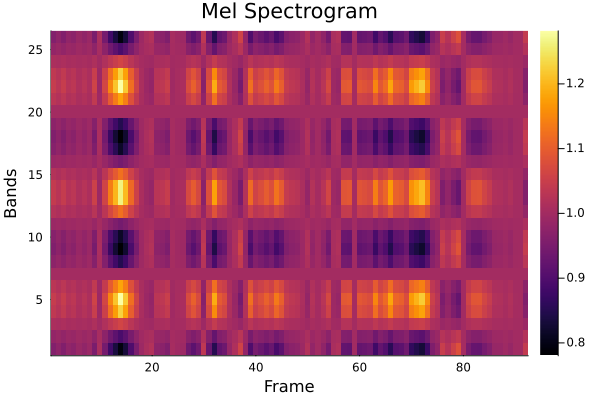

In [76]:
mfcc_s7 = zeros(size(mfccspec.mfcc))
mfcc_s7[7, :] = mfccspec.mfcc[7, :]
mfcc7 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s7,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc7.mfcc, n_mels=melspec.nbands)
rec_spc7 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc7)

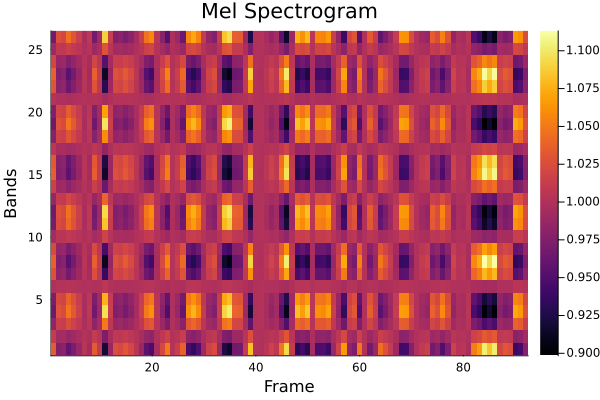

In [77]:
mfcc_s8 = zeros(size(mfccspec.mfcc))
mfcc_s8[8, :] = mfccspec.mfcc[8, :]
mfcc8 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s8,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc8.mfcc, n_mels=melspec.nbands)
rec_spc8 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc8)

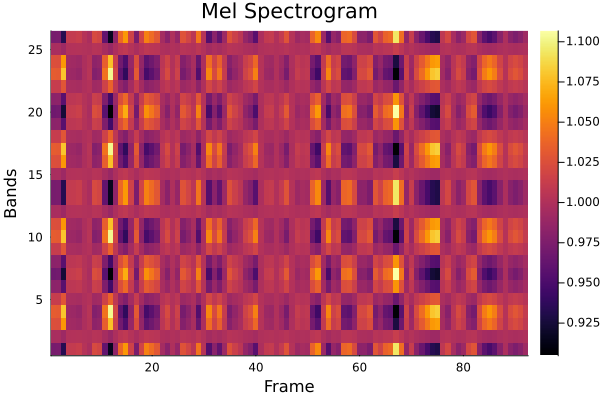

In [78]:
mfcc_s9 = zeros(size(mfccspec.mfcc))
mfcc_s9[9, :] = mfccspec.mfcc[9, :]
mfcc9 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s9,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc9.mfcc, n_mels=melspec.nbands)
rec_spc9 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc9)

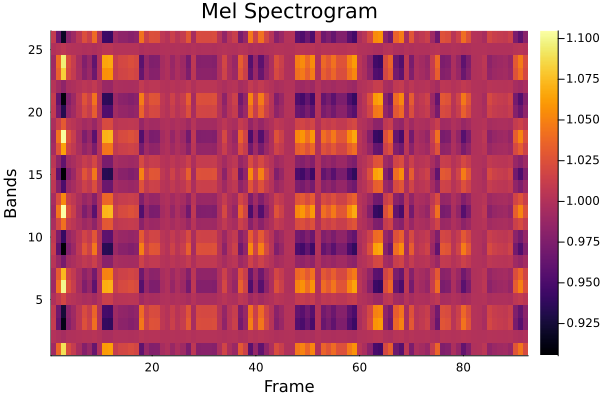

In [79]:
mfcc_s10 = zeros(size(mfccspec.mfcc))
mfcc_s10[10, :] = mfccspec.mfcc[10, :]
mfcc10 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s10,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc10.mfcc, n_mels=melspec.nbands)
rec_spc10 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc10)

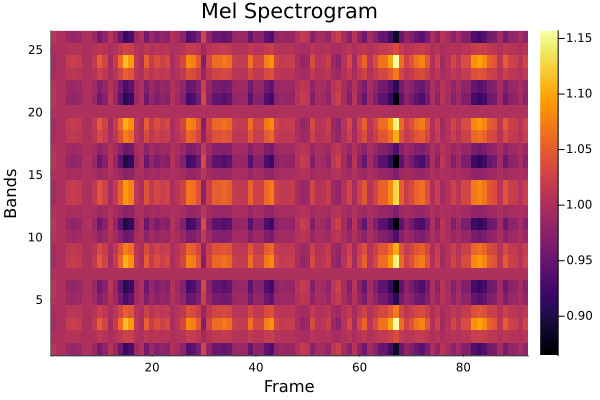

In [80]:
mfcc_s11 = zeros(size(mfccspec.mfcc))
mfcc_s11[11, :] = mfccspec.mfcc[11, :]
mfcc11 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s11,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc11.mfcc, n_mels=melspec.nbands)
rec_spc11 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc11)

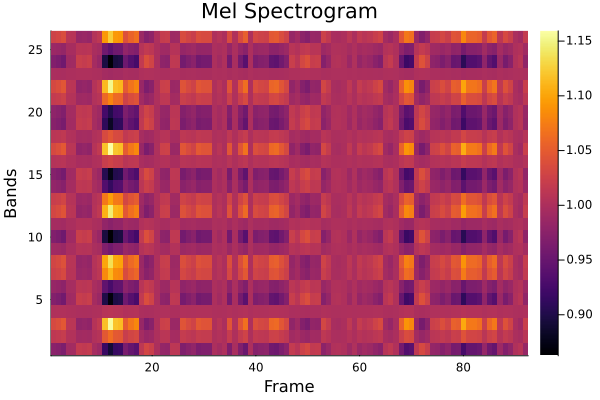

In [81]:
mfcc_s12 = zeros(size(mfccspec.mfcc))
mfcc_s12[12, :] = mfccspec.mfcc[12, :]
mfcc12 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s12,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc12.mfcc, n_mels=melspec.nbands)
rec_spc12 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc12)

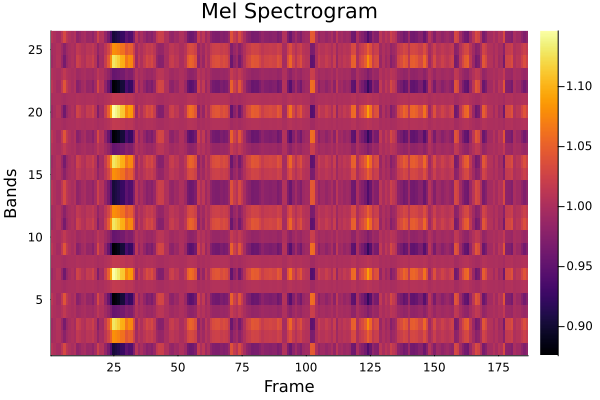

In [40]:
mfcc_s13 = zeros(size(mfccspec.mfcc))
mfcc_s13[13, :] = mfccspec.mfcc[13, :]
mfcc13 = Mfcc(
    sr = mfccspec.sr,
    nbands = melspec.nbands,
    ncoeffs = mfccspec.ncoeffs,
    mfcc = mfcc_s13,
    freq = mfccspec.freq,
)
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfcc13.mfcc, n_mels=melspec.nbands)
rec_spc13 = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(rec_spc13)

In [41]:
inv_audio = librosa.feature.inverse.mfcc_to_audio(mfcc13.mfcc, sr=audio.sr, n_mels=26, n_fft=512, hop_length=256, win_length=512, window="hann", n_iter=32)
wavplay(inv_audio, audio.sr)